# BNN with Variational Inference (VI) for predicting Band Gaps

In [15]:
import pyro
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.distributions as dist

from pyro.infer import MCMC, NUTS, Predictive, SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.optim import Adam
from tqdm.auto import trange

from BNN_VI_model import BNN

### Load and preprocess the data 

In [16]:
df_mp = pd.read_csv('/home/april-ai/Desktop/UQ/MC_Dropout/10k_data_cleaned.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/home/april-ai/Desktop/UQ/MC_Dropout/10k_data_cleaned.csv'

In [ ]:
df_mp = df_mp[(df_mp['band_gap'] > 0.2)]
y = df_mp['band_gap']

In [ ]:
y = df_mp['band_gap'].values
excluded = ["material_id", "composition", "formula_pretty", "symmetry", "structure", "sites", 'HOMO_character', 'HOMO_element', 'LUMO_character', 'LUMO_element']
X = df_mp.drop(columns=excluded + ["band_gap"], errors='ignore')
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

In [ ]:
#Train tes split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Drop non-numeric / irrelevant fields
non_feature_cols = [
    "sites", "composition", "formula_pretty", "structure", "symmetry",
    "material_id", "HOMO_character", "HOMO_element", "LUMO_character", "LUMO_element"
]
df = df_mp.drop(columns=non_feature_cols, errors='ignore')
df = df.dropna(subset=["band_gap"])


df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(0)
# Save original indices
original_indices = np.arange(len(df))

# Split first — before scaling — and keep track of original indices
X_raw = df.drop(columns=["band_gap"])
y_raw = df["band_gap"]

X_train_raw, X_test_raw, y_train_raw, y_test_raw, idx_train, idx_test = train_test_split(
    X_raw, y_raw, original_indices, test_size=0.2, random_state=42
)


In [ ]:
# Normalise training data
scaler_x = StandardScaler()
scaler_y = StandardScaler()


X_train = scaler_x.fit_transform(X_train_raw) #computes mean and std from training data and scales it
X_test = scaler_x.transform(X_test_raw) #uses the same mean and std to scale test data

#y_train = scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1)).ravel()
#y_test = scaler_y.transform(y_test_raw.values.reshape(-1, 1)).ravel() #ravel() flattens the output back to 1D, which is typically needed for PyTorch models expecting targets as flat vectors.

# Convert to Pytorch tensors
#C onverts the NumPy arrays into torch.tensor objects, which are the format needed for training/testing the BNN in PyTorch.
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_raw, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_raw, dtype=torch.float32)

### Train the model

In [ ]:
pyro.clear_param_store()

model = BNN(input_dim=X_train.shape[1], hid_dim=64, n_hid_layers=2, prior_scale=1.0)
guide = AutoDiagonalNormal(model)
optimizer = Adam({"lr": 1e-3})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

num_epochs = 3000
progress_bar = trange(num_epochs)

# Add before training loop
train_losses = []
val_losses = []

for epoch in progress_bar:
    train_loss = svi.step(X_train_tensor, y_train_tensor) / X_train_tensor.shape[0]
    val_loss = svi.evaluate_loss(X_test_tensor, y_test_tensor) / X_test_tensor.shape[0]
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    progress_bar.set_postfix(loss=f"{train_loss:.4f}", val_loss=f"{val_loss:.4f}")

for epoch in progress_bar:
    loss = svi.step(X_train_tensor, y_train_tensor)
    progress_bar.set_postfix(loss=f"{loss / X_train_tensor.shape[0]:.4f}")

  0%|          | 0/3000 [00:00<?, ?it/s]

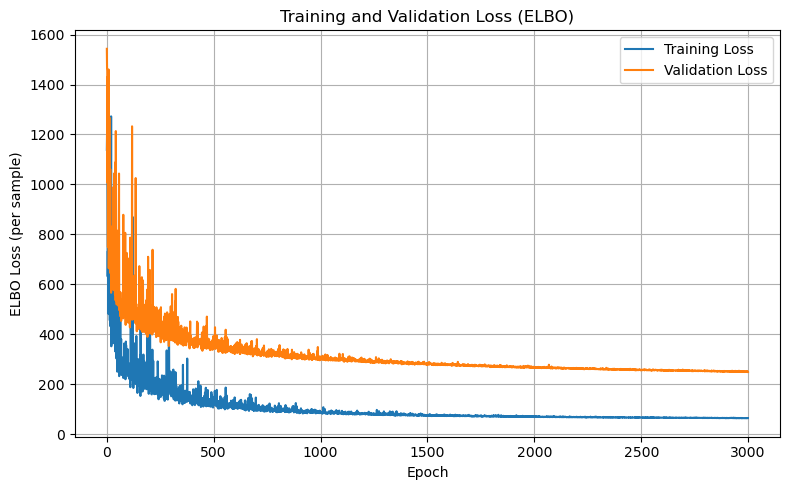

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("ELBO Loss (per sample)")
plt.legend()
plt.title("Training and Validation Loss (ELBO)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
predictive = Predictive(model, guide=guide, num_samples=500, return_sites=["obs"])
pred_samples = predictive(X_test_tensor)["obs"]  # shape: [500, num_test]
mean_pred = pred_samples.mean(dim=0).detach().numpy()
std_pred = pred_samples.std(dim=0).detach().numpy()

# Inverse-transform predictions
mean_pred_actual = mean_pred #scaler_y.inverse_transform(mean_pred.reshape(-1, 1)).ravel()
std_pred_actual = std_pred #* scaler_y.scale_[0]
y_test_actual = y_test #scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

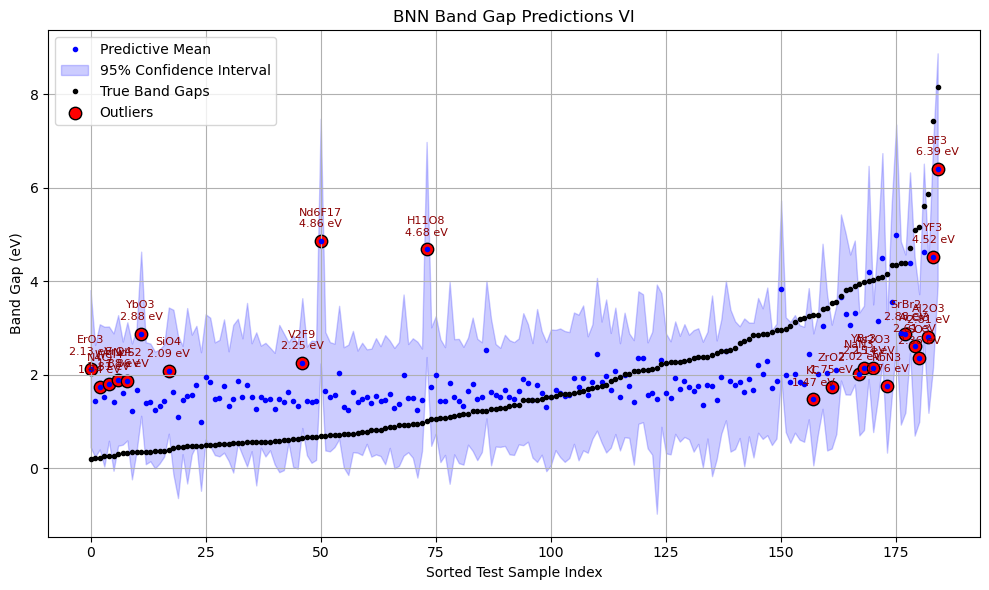

In [ ]:
# Sort by actual test values
sorted_indices = np.argsort(y_test_actual)
x = np.arange(len(y_test_actual))

# Sorted arrays
sorted_y_test_actual = y_test_actual[sorted_indices]
sorted_mean_pred_actual = mean_pred_actual[sorted_indices]
sorted_std_pred_actual = std_pred_actual[sorted_indices]

# Compute errors and find outliers
errors = np.abs(sorted_mean_pred_actual - sorted_y_test_actual)
outlier_mask = errors > 1.5
outlier_indices = np.where(outlier_mask)[0]

# Map back to original indices to get formulas
outlier_test_indices = sorted_indices[outlier_indices]
outlier_original_indices = idx_test[outlier_test_indices]
formulas = df_mp.iloc[outlier_original_indices]["formula_pretty"].values

# Plotting
plt.figure(figsize=(10, 6))

# Predictive mean ±1σ
plt.plot(x, sorted_mean_pred_actual, 'b.', label="Predictive Mean")
plt.fill_between(
    x,
    sorted_mean_pred_actual - sorted_std_pred_actual,
    sorted_mean_pred_actual + sorted_std_pred_actual,
    alpha=0.2,
    color='blue',
    label="95% Confidence Interval"
)

# Ground truth values
plt.plot(x, sorted_y_test_actual, 'k.', label="True Band Gaps")

# Outliers
plt.scatter(
    x[outlier_indices], sorted_mean_pred_actual[outlier_indices],
    color='red', edgecolor='black', s=80, label="Outliers"
)

# Annotate outliers
for i, idx in enumerate(outlier_indices):
    pred_val = sorted_mean_pred_actual[idx]
    formula = formulas[i]
    plt.annotate(
        f"{formula}\n{pred_val:.2f} eV",
        (x[idx], pred_val),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center',
        fontsize=8,
        color='darkred'
    )

# Final plot formatting
plt.title("BNN Band Gap Predictions VI")
plt.xlabel("Sorted Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
